In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
import os
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [189]:
def save_video(videodata,ofn='outvideo.mp4'):
    import skvideo
    import skvideo.io
    #skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8))

In [4]:
def get_mask_resized_num(targ,mask):
    im2 = Image.fromarray((mask*255).astype(np.uint8)).resize(size=(targ[1],targ[0]), resample=PIL.Image.NEAREST)
    return np.array(im2)

In [5]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

In [6]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [37]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [58]:
def plot_frames(arr):
    nframes = arr.shape[0]
    plt.figure(figsize=(20,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr[int(i),:,:,0:3])
    plt.show()

In [131]:
def bg_inpaint(bg,mask,inpaint_radius=3,inpainting=cv2.INPAINT_TELEA):
    #cv2.INPAINT_TELEA or cv2.INPAINT_NS)
    #bg_inpainted = cv2.inpaint((bg[:,:,0:3]*255).astype(np.uint8),mask,inpaint_radius,inpainting)
    bg_inpainted = cv2.inpaint((bg[:,:,0:3]).astype(np.uint8),mask,inpaint_radius,inpainting)
    return bg_inpainted

In [7]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'

In [8]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
n = len(folders)
print(n)
folders[0:3]

499


['ALS_IceBucket_Challenge', 'CPR', 'abseiling']

In [9]:
fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'

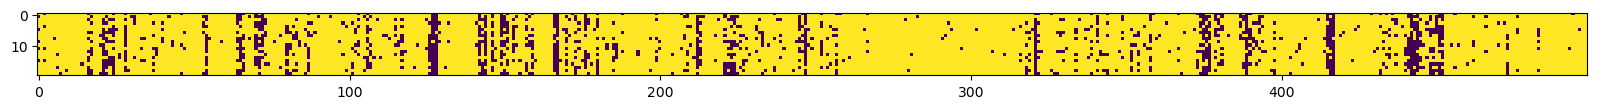

In [10]:
good_videos = np.load('good_videos.npy')
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

In [11]:
good_videos.shape

(20, 499)

In [12]:
a = np.load('./Data/data_good_videos.npz')
masks = a['masks']
fns = a['fns']
paddings = a['paddings']
paddings = (paddings==0)*1

del a

print(masks.shape)
print(fns.shape)
print(paddings.shape)

(8533, 360, 640)
(8533,)
(8533, 360, 640)


In [13]:
a = np.load('./Data/data_inpainting_idx.npz')
filled_spots = a['filled_spots']
spots_found_for = a['spots_found_for']
where_to_inpaint_idx = a['where_to_inpaint_idx']

del a

print(filled_spots.shape)
print(spots_found_for.shape)
print(where_to_inpaint_idx.shape)
print(spots_found_for.sum())    

(8533,)
(8533,)
(8533,)
2266


In [22]:
n = spots_found_for.sum()
print(n)

2266


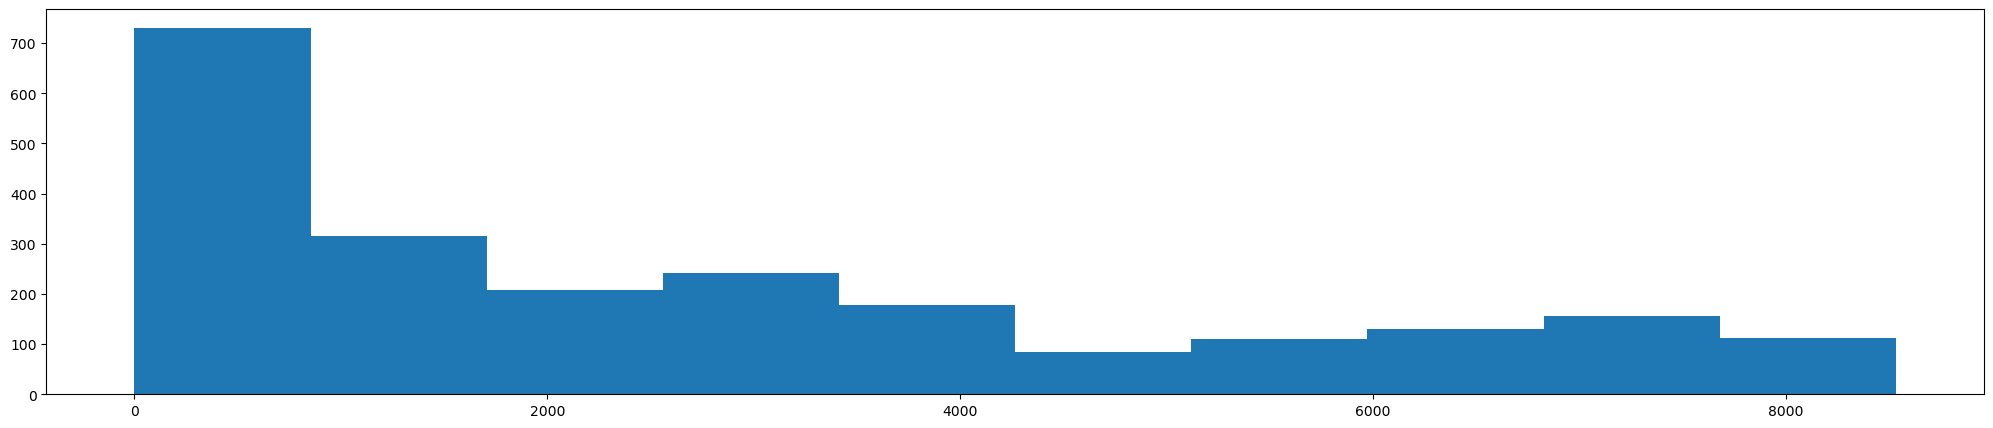

In [35]:
spots_found_for_idx = np.nonzero(spots_found_for)[0]
plt.figure(figsize=(25,5));
plt.hist(spots_found_for_idx);

In [174]:
i = 8

In [175]:
vid_id = spots_found_for_idx[i]
vid_inpaint_id = int(where_to_inpaint_idx[vid_id])

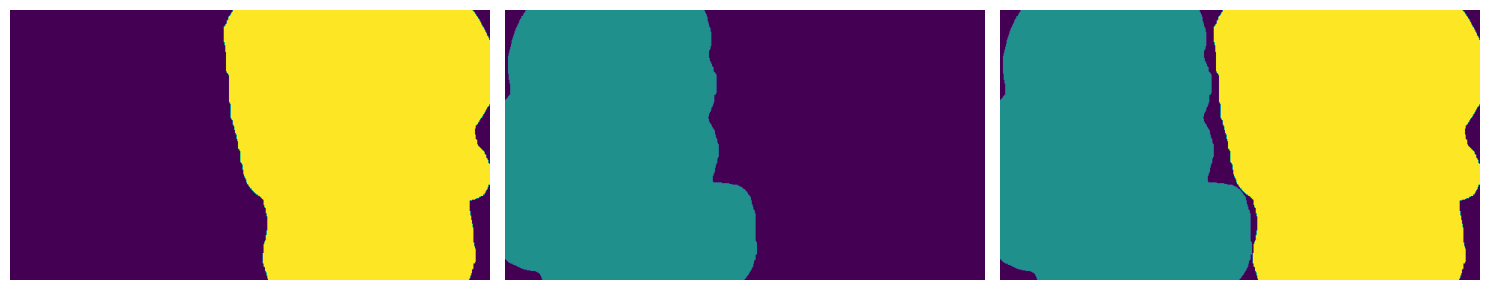

In [176]:
plot_triple(masks[vid_id,:,:],masks[vid_inpaint_id,:,:]+paddings[vid_inpaint_id,:,:])

In [177]:
print(fns[vid_id])
print(fns[vid_inpaint_id])

/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4/ALS_IceBucket_Challenge/ALS_IceBucket_Challenge_012_item_0_masks.npy
/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4/play_accordian/play_accordian_007_item_0_masks.npy


In [183]:
video_data_inv_seg = load_video(fns[vid_id].replace('_masks.npy','_inv_seg.mp4'))
video_data_inp_seg = load_video(fns[vid_id].replace('_masks.npy','_inp_seg.mp4'))
video_data_fwd_seg = load_video(fns[vid_id].replace('_masks.npy','_fwd_seg.mp4'))
video_data_orig = load_video(fns[vid_id].replace('_item_0_masks.npy','.mp4'))


video_data_inp_orig = load_video(fns[vid_inpaint_id].replace('_item_0_masks.npy','.mp4'))
video_data_inp_fwd_seg = load_video(fns[vid_inpaint_id].replace('_masks.npy','_fwd_seg.mp4'))
#video_data_inp = load_video(fns[vid_inpaint_id].replace('_masks.npy','_inv_seg.mp4'))

In [179]:
use_mask = masks[vid_id,:,:]
use_mask[use_mask>0]=255
use_mask = use_mask.astype(np.uint8)

In [180]:
arr = [bg_inpaint(video_data_inp_orig[jj,:,:,:],use_mask,inpaint_radius=5,inpainting=cv2.INPAINT_TELEA) for jj in range(video_data_inp_orig.shape[0])]

In [181]:
arr = np.array(arr).astype(np.uint8)

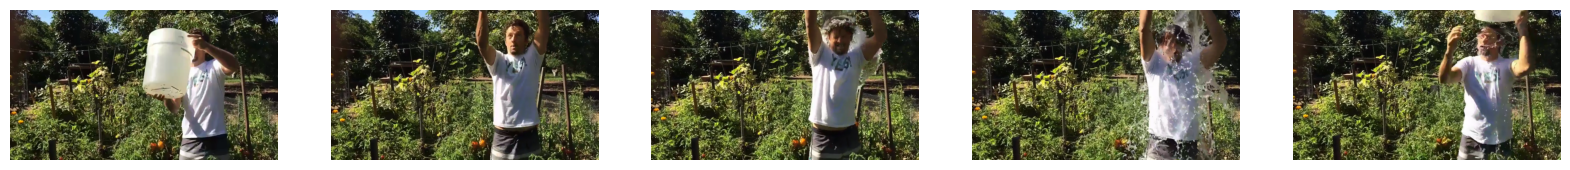

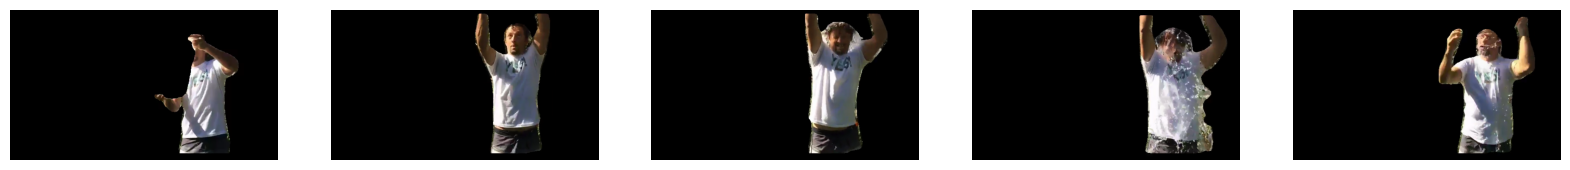

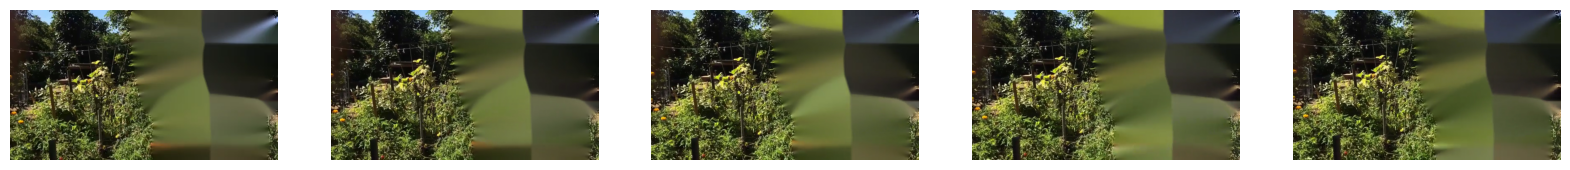

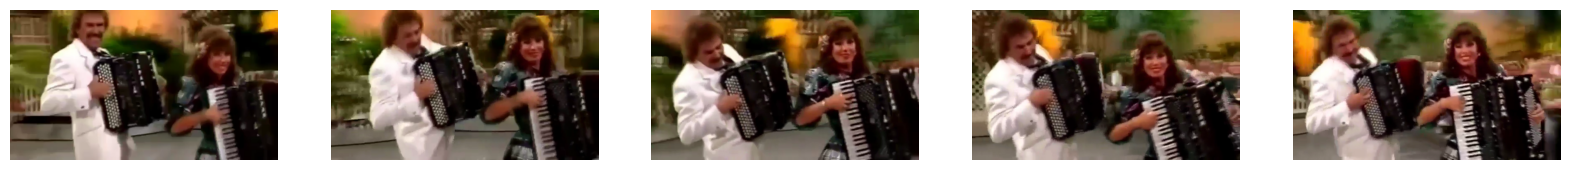

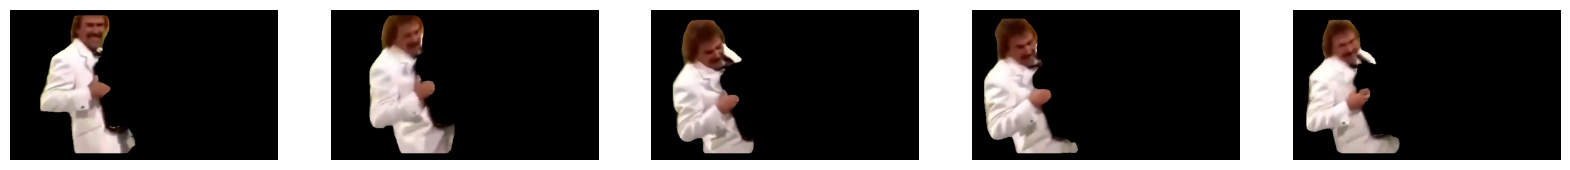

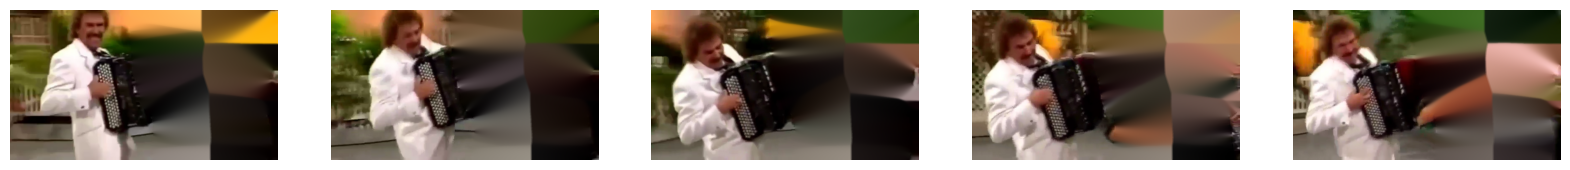

In [186]:
plot_frames(video_data_orig)
plot_frames(video_data_fwd_seg)
plot_frames(video_data_inp_seg)

plot_frames(video_data_inp_orig)
plot_frames(video_data_inp_fwd_seg)
plot_frames(arr)

In [190]:
save_video(arr,fns[vid_id].replace('_masks.npy','_inp_rnd.mp4'))

In [201]:
frame_check = (load_video(fns[vid_id].replace('_masks.npy','_inp_rnd.mp4')).shape[0],arr.shape[0])

In [202]:
frame_check

(57, 57)

In [203]:
assert frame_check[0]==frame_check[1],'frames mismatch'